In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp
import psycopg2
import sys
sys.path.extend(['..', '../..'])
from postgis.psycopg import register
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry import box
from db_importer.settings import *

class DatabaseConnection(object):
    def __enter__(self):
        self.conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
        self.conn.autocommit = True

        register(self.conn)
        self.cur = self.conn.cursor()

        return self.cur

    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_tb is None:
            self.conn.commit()
            self.cur.close()
            self.conn.close()
        else:
            self.conn.rollback()
            self.cur.close()
            self.conn.close()

In [2]:
#files= ['sim_data/b1_default.csv', 'sim_data/b1_default_ped.csv', 'sim_data/b1_new_params.csv', 'sim_data/b1_new_params_ped.csv']
files = ['sim_data/frauentorgraben_new_params_all.csv', 'sim_data/frauentorgraben_new_params_slow.csv', 'sim_data/frauentorgraben_new_params_medium.csv', 'sim_data/frauentorgraben_new_params_fast.csv', 'sim_data/frauentorgraben_default.csv',]

def calc_a_min_filtered(group):
    a = (group['vehicle_speed'] - group.shift(1)['vehicle_speed']) / 1 #timestep_time is always 1
    a = a[a > -1.64]
    return a.min()

def calc_a_min(group):
    a = (group['vehicle_speed'] - group.shift(1)['vehicle_speed']) / 1 #timestep_time is always 1
    return a.min()

def calc_a_max(group):
    a = (group['vehicle_speed'] - group.shift(1)['vehicle_speed']) / 1 #timestep_time is always 1
    return a.max()

max_accs_arr = []
max_decs_arr = []
max_velos_arr = []

for file in files:
    df = pd.read_csv(file, delimiter=';')
    # print("df:\n{}".format(df))
    print(file)
    # print(len(df))
    df = df[df.vehicle_id.str.startswith('f_', na=False)]
    # print(len(df))
    grouped = df.groupby('vehicle_id', group_keys=False)
    # print(grouped)
    max_accs_arr.append(grouped.apply(calc_a_max).values)
    if "default" in file:
        max_decs_arr.append(grouped.apply(calc_a_min).values)
    else:
        max_decs_arr.append(grouped.apply(calc_a_min_filtered).values)

    max_velos = []
    
    for key, item in grouped:
        max_velos.append(max(grouped.get_group(key)['vehicle_speed']))
        
    max_velos_arr.append(max_velos)

sim_data/frauentorgraben_new_params_all.csv
sim_data/frauentorgraben_new_params_slow.csv
sim_data/frauentorgraben_new_params_medium.csv
sim_data/frauentorgraben_new_params_fast.csv
sim_data/frauentorgraben_default.csv


In [3]:
##frauentorgraben
with DatabaseConnection() as cur:
    group_q = lambda perc: f"""SELECT percentile_cont({perc}) WITHIN GROUP (ORDER BY one.avg_v) FROM (SELECT AVG(velo) as avg_v FROM accels WHERE velo > 0.2 AND velo != 'NaN' AND velo < 15 GROUP BY filename) as one"""
    cur.execute(f"""
            SELECT two.filename, two.max_v, one.accel, one.decel, CASE WHEN two.avg_v < ({group_q(0.25)}) THEN 0 ELSE CASE WHEN two.avg_v < ({group_q(0.75)}) THEN 1 ELSE 2 END END as group FROM (
                SELECT filename, MAX(accel) as accel, MIN(accel) as decel FROM accels GROUP BY filename
            ) as one JOIN (
                SELECT filename, SUM(velo * duration)/SUM(duration) as avg_v, MAX(velo) as max_v FROM accels WHERE velo > 0.2 AND velo != 'NaN' and velo < 15 GROUP BY filename
            ) as two ON (one.filename = two.filename) JOIN ride as r ON (one.filename = r.filename)
            WHERE st_intersects(r.geom,
                    st_setsrid( st_makebox2d( st_makepoint(11.079800456,49.446282173), st_makepoint(11.0811070204,49.446850658)), 4326))
                AND st_intersects(r.geom,
                    st_setsrid( st_makebox2d( st_makepoint(11.067365735,49.4470913205), st_makepoint(11.0686722994,49.4476597962)), 4326))""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'max_v', 'max_accel', 'max_decel', 'group'])

In [4]:
a_simra = df.query('max_accel >= 0.3')[['max_accel']]
a_simra_slow = df.query('group == 0 and max_accel >= 0.3')[['max_accel']]
a_simra_medium = df.query('group == 1 and max_accel >= 0.3')[['max_accel']]
a_simra_fast = df.query('group == 2 and max_accel >= 0.3')[['max_accel']]
print(a_simra_slow.info())
print(a_simra_medium.info())
print(a_simra_fast.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 98
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   max_accel  74 non-null     float64
dtypes: float64(1)
memory usage: 1.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 5 to 99
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   max_accel  22 non-null     float64
dtypes: float64(1)
memory usage: 352.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 11 to 77
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   max_accel  4 non-null      float64
dtypes: float64(1)
memory usage: 64.0 bytes
None


In [5]:
v = df[['max_v']]
v_slow = df.query('group == 0')[['max_v']]
v_medium = df.query('group == 1')[['max_v']]
v_fast = df.query('group == 2')[['max_v']]

In [6]:
d_simra = df.query('max_decel < -0.1')[['max_decel']]
d_simra_slow = df.query('group == 0 and max_decel < -0.1')[['max_decel']]
d_simra_medium = df.query('group == 1 and max_decel < -0.1')[['max_decel']]
d_simra_fast = df.query('group == 2 and max_decel < -0.1')[['max_decel']]

In [7]:
# plotting config
columnwidth = 3.5
textwidth = 3.5 * 2 + 0.25
figsize = (columnwidth * 0.97, 1.75)
# figsize = (columnwidth * 1.94, 1.75)
params = {
     "pdf.fonttype": 42,
     "font.family": "serif",
     "font.serif": "Linux Libertine",
     "font.sans-serif": [],
     "font.monospace": [],
     # Make the legend/label fonts a little smaller
     "font.size": 8,
     "axes.labelsize": 8,
     "axes.titlesize": 8,
     "legend.fontsize": 6,
     "legend.title_fontsize": 8,
     "xtick.labelsize": 7,
     "ytick.labelsize": 7,
     "figure.figsize": figsize,
     "figure.autolayout": True,
     # save some space around figures when saving
     "savefig.bbox": "tight",
     "savefig.pad_inches": 0.025,
}
pdf_params = {
     "text.usetex": True,
     "pgf.texsystem": "pdflatex",
     "pgf.rcfonts": False,
     "pgf.preamble": "\n".join(
         [
             # put LaTeX preamble declarations here
             r"\usepackage[utf8x]{inputenc}",
             r"\usepackage[T1]{fontenc}",
         ]
     ),
}
# for PFG plotting:
params.update(**pdf_params)
plt.rcParams.update(params)

In [8]:
def calc_stats(default, our, simra, group, type):
    #mean, std, median - amax (fast)

    print(f"(SUMO Default) {type} - mean: " + str(np.mean(default)))
    print(f"(SUMO Default) {type} - std: " + str(np.std(default)))
    print(f"(SUMO Default) {type} - median: " + str(np.median(default)))

    print(f"(Our approach - {group}) {type} - mean: " + str(np.mean(our)))
    print(f"(Our approach - {group}) {type} - std: " + str(np.std(our)))
    print(f"(Our approach - {group}) {type} - median: " + str(np.median(our)))

    print(f"(SimRa - {group}) {type} - mean: " + str(np.mean(simra)))
    print(f"(SimRa - {group}) {type} - std: " + str(np.std(simra)))
    print(f"(SimRa - {group}) {type} - median: " + str(np.median(simra)))

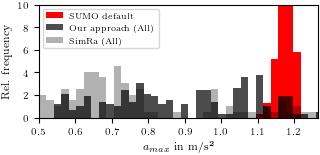

In [9]:
# a_max - all
# plt.subplots(figsize = (10, 5))
bins = np.linspace(0.5,1.3,40)
plt.hist(max_accs_arr[4], bins=bins, label='SUMO default', color = 'red', density=True)
plt.hist(max_accs_arr[0], bins=bins, label='Our approach (All)', color = 'black', density=True, alpha=0.7)
plt.hist(a_simra.values.flatten(), bins=bins, label='SimRa (All)', color = 'black', density=True, alpha=0.3)
plt.ylim(0,10)
plt.xlim(0.5,1.265)
plt.ylabel('Rel. frequency')
plt.legend()
plt.xlabel(r'$a_{max}$ in m/s²')
# plt.savefig('images/sim_frauentorgraben_acc_all.pdf', bbox_inches='tight')
plt.show()


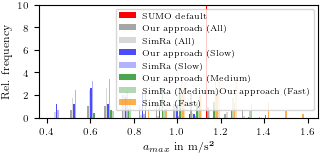

In [10]:
# a_max - everything
# plt.subplots(figsize = (10, 5))
red = matplotlib.colors.to_rgba('red', alpha=1)
grey = matplotlib.colors.to_rgba('grey', alpha=0.7)
lightgrey = matplotlib.colors.to_rgba('grey', alpha=0.3)
blue = matplotlib.colors.to_rgba('blue', alpha=0.7)
lightblue = matplotlib.colors.to_rgba('blue', alpha=0.3)
green = matplotlib.colors.to_rgba('green', alpha=0.7)
lightgreen = matplotlib.colors.to_rgba('green', alpha=0.3)
orange = matplotlib.colors.to_rgba('darkorange', alpha=0.7)
lightorange = matplotlib.colors.to_rgba('darkorange', alpha=0.3)
colors = [red, grey, lightgrey, blue, lightblue, green, lightgreen, orange, lightorange]
plt.hist([max_accs_arr[4], max_accs_arr[0], a_simra.values.flatten(), max_accs_arr[1], a_simra_slow.values.flatten(), max_accs_arr[2], a_simra_medium.values.flatten(), max_accs_arr[3], a_simra_fast.values.flatten()], bins = 15, label=['SUMO default', 'Our approach (All)', 'SimRa (All)', 'Our approach (Slow)', 'SimRa (Slow)', 'Our approach (Medium)', 'SimRa (Medium)' 'Our approach (Fast)', 'SimRa (Fast)'], color = colors, density=True)
plt.legend()
plt.ylim(0,10)
# plt.xlim(0.5,1.265)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$a_{max}$ in m/s²')
plt.savefig('images/sim_frauentorgraben_acc_everything.pdf', bbox_inches='tight')
plt.show()

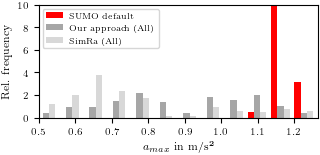

(SUMO Default) amax - mean: 1.17760896
(SUMO Default) amax - std: 0.019466840947751845
(SUMO Default) amax - median: 1.183249
(Our approach - all) amax - mean: 0.9206100666666667
(Our approach - all) amax - std: 0.21752131189636467
(Our approach - all) amax - median: 0.9470000000000001
(SimRa - all) amax - mean: 0.761304087652443
(SimRa - all) amax - std: 0.217130939984466
(SimRa - all) amax - median: 0.7067198365648071


In [11]:
# a_max - all
# plt.subplots(figsize = (10, 5))
red = matplotlib.colors.to_rgba('red', alpha=1)
grey = matplotlib.colors.to_rgba('grey', alpha=0.7)
lightgrey = matplotlib.colors.to_rgba('grey', alpha=0.3)
colors = [red, grey, lightgrey]
plt.hist([max_accs_arr[4], max_accs_arr[0], a_simra.values.flatten()], bins = 15, label=['SUMO default', 'Our approach (All)', 'SimRa (All)'], color = colors, density=True)
plt.legend()
plt.ylim(0,10)
plt.xlim(0.5,1.265)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$a_{max}$ in m/s²')
plt.savefig('images/sim_frauentorgraben_acc_all.pdf', bbox_inches='tight')
plt.show()
calc_stats(max_accs_arr[4], max_accs_arr[0], a_simra.values.flatten(), "all", "amax")

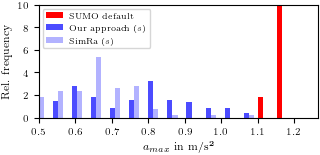

(SUMO Default) amax - mean: 1.17760896
(SUMO Default) amax - std: 0.019466840947751845
(SUMO Default) amax - median: 1.183249
(Our approach - slow) amax - mean: 0.7271100000000001
(Our approach - slow) amax - std: 0.16836202432060898
(Our approach - slow) amax - median: 0.7360000000000002
(SimRa - slow) amax - mean: 0.6559527268651316
(SimRa - slow) amax - std: 0.10889300502525939
(SimRa - slow) amax - median: 0.6488532209101625


In [12]:
# a_max - slow
# plt.subplots(figsize = (10, 5))
red = matplotlib.colors.to_rgba('red', alpha=1)
blue = matplotlib.colors.to_rgba('blue', alpha=0.7)
lightblue = matplotlib.colors.to_rgba('blue', alpha=0.3)
colors = [red, blue, lightblue]
plt.hist([max_accs_arr[4], max_accs_arr[1], a_simra_slow.values.flatten()], bins = 15, label=['SUMO default', r'Our approach ($s$)', r'SimRa ($s$)'], color = colors, density=True)
plt.legend()
plt.ylim(0,10)
plt.xlim(0.5,1.265)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$a_{max}$ in m/s²')
plt.savefig('images/sim_frauentorgraben_acc_slow.pdf', bbox_inches='tight')
plt.show()
#take
calc_stats(max_accs_arr[4], max_accs_arr[1], a_simra_slow.values.flatten(), "slow", "amax")


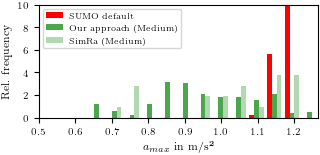

(SUMO Default) amax - mean: 1.17760896
(SUMO Default) amax - std: 0.019466840947751845
(SUMO Default) amax - median: 1.183249
(Our approach - medium) amax - mean: 0.96553344
(Our approach - medium) amax - std: 0.16310588591208594
(Our approach - medium) amax - median: 0.9360000000000003
(SimRa - medium) amax - mean: 1.0495785386197958
(SimRa - medium) amax - std: 0.16762447957329538
(SimRa - medium) amax - median: 1.076464903422089


In [13]:
# a_max - medium
# plt.subplots(figsize = (10, 5))
red = matplotlib.colors.to_rgba('red', alpha=1)
green = matplotlib.colors.to_rgba('green', alpha=0.7)
lightgreen = matplotlib.colors.to_rgba('green', alpha=0.3)
colors = [red, green, lightgreen]
plt.hist([max_accs_arr[4], max_accs_arr[2], a_simra_medium.values.flatten()], bins = 15, label=['SUMO default', 'Our approach (Medium)', 'SimRa (Medium)'], color = colors, density=True)
plt.legend()
plt.ylim(0,10)
plt.xlim(0.5,1.265)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$a_{max}$ in m/s²')
plt.savefig('images/sim_frauentorgraben_acc_medium.pdf', bbox_inches='tight')
plt.show()
calc_stats(max_accs_arr[4], max_accs_arr[2], a_simra_medium.values.flatten(), "medium", "amax")

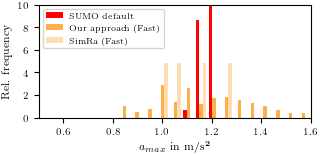

(SUMO Default) amax - mean: 1.17760896
(SUMO Default) amax - std: 0.019466840947751845
(SUMO Default) amax - median: 1.183249
(Our approach - fast) amax - mean: 1.1655620869565217
(Our approach - fast) amax - std: 0.18241488358724195
(Our approach - fast) amax - median: 1.159982
(SimRa - fast) amax - mean: 1.124794781897261
(SimRa - fast) amax - std: 0.10110851725805953
(SimRa - fast) amax - median: 1.1299580350969904


In [14]:
# a_max - fast
# plt.subplots(figsize = (10, 5))
red = matplotlib.colors.to_rgba('red', alpha=1)
orange = matplotlib.colors.to_rgba('darkorange', alpha=0.7)
lightorange = matplotlib.colors.to_rgba('darkorange', alpha=0.3)
colors = [red, orange, lightorange]
plt.hist([max_accs_arr[4], max_accs_arr[3], a_simra_fast.values.flatten()], bins = 15, label=['SUMO default', 'Our approach (Fast)', 'SimRa (Fast)'], color = colors, density=True)
plt.legend()
plt.ylim(0,10)
plt.xlim(0.5,1.6)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$a_{max}$ in m/s²')
plt.savefig('images/sim_frauentorgraben_acc_fast.pdf', bbox_inches='tight')
plt.show()
calc_stats(max_accs_arr[4], max_accs_arr[3], a_simra_fast.values.flatten(), "fast", "amax")

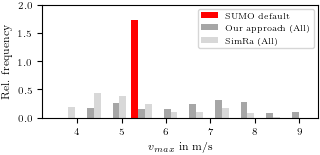

In [15]:
# v_max - all
# plt.subplots(figsize = (10, 5))
red = matplotlib.colors.to_rgba('red', alpha=1)
grey = matplotlib.colors.to_rgba('grey', alpha=0.7)
lightgrey = matplotlib.colors.to_rgba('grey', alpha=0.3)
colors = [red, grey, lightgrey]
plt.hist([max_velos_arr[4], max_velos_arr[0], v.values.flatten()], bins = 10, label=['SUMO default', 'Our approach (All)', 'SimRa (All)'], color = colors, density=True)
plt.legend()
plt.ylim(0,2.0)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$v_{max}$ in m/s')
plt.savefig('images/sim_frauentorgraben_vel_all.pdf', bbox_inches='tight')
plt.show()

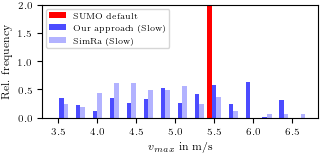

In [16]:
# v_max - slow
# plt.subplots(figsize = (10, 5))
red = matplotlib.colors.to_rgba('red', alpha=1)
blue = matplotlib.colors.to_rgba('blue', alpha=0.7)
lightblue = matplotlib.colors.to_rgba('blue', alpha=0.3)
colors = [red, blue, lightblue]
plt.hist([max_velos_arr[4], max_velos_arr[1], v_slow.values.flatten()], bins = 15, label=['SUMO default', 'Our approach (Slow)', 'SimRa (Slow)'], color = colors, density=True)
plt.legend()
plt.ylim(0,2.0)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$v_{max}$ in m/s')
plt.savefig('images/sim_frauentorgraben_vel_slow.pdf', bbox_inches='tight')
plt.show()

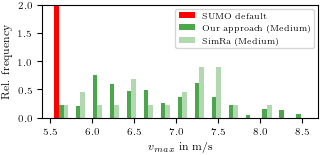

In [17]:
# v_max - medium
# plt.subplots(figsize = (10, 5))
red = matplotlib.colors.to_rgba('red', alpha=1)
green = matplotlib.colors.to_rgba('green', alpha=0.7)
lightgreen = matplotlib.colors.to_rgba('green', alpha=0.3)
colors = [red, green, lightgreen]
plt.hist([max_velos_arr[4], max_velos_arr[2], v_medium.values.flatten()], bins = 15, label=['SUMO default', 'Our approach (Medium)', 'SimRa (Medium)'], color = colors, density=True)
plt.legend()
plt.ylim(0,2.0)
# plt.xlim(5.4,8.1)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$v_{max}$ in m/s')
plt.savefig('images/sim_frauentorgraben_vel_medium.pdf', bbox_inches='tight')
plt.show()

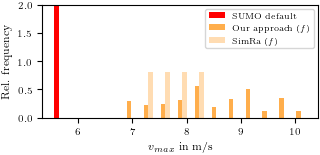

In [18]:
# v_max - fast
# plt.subplots(figsize = (10, 5))
red = matplotlib.colors.to_rgba('red', alpha=1)
orange = matplotlib.colors.to_rgba('darkorange', alpha=0.7)
lightorange = matplotlib.colors.to_rgba('darkorange', alpha=0.3)
colors = [red, orange, lightorange]
plt.hist([max_velos_arr[4], max_velos_arr[3], v_fast.values.flatten()], bins = 15, label=['SUMO default', r'Our approach ($f$)', r'SimRa ($f$)'], color = colors, density=True)
plt.legend()
plt.ylim(0,2.0)
# plt.xlim(5.4,8.1)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$v_{max}$ in m/s')
plt.savefig('images/sim_frauentorgraben_vel_fast.pdf', bbox_inches='tight')
plt.show()

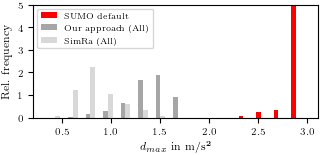

In [19]:
# d_max - all
# plt.subplots(figsize = (10, 5))
red = matplotlib.colors.to_rgba('red', alpha=1)
grey = matplotlib.colors.to_rgba('grey', alpha=0.7)
lightgrey = matplotlib.colors.to_rgba('grey', alpha=0.3)
colors = [red, grey, lightgrey]
plt.hist([np.absolute(max_decs_arr[4]), np.absolute(max_decs_arr[0]), np.absolute(d_simra.values.flatten())], bins = 15, label=['SUMO default', 'Our approach (All)', 'SimRa (All)'], color = colors, density=True)
plt.legend()
plt.ylim(0,5)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$d_{max}$ in m/s²')
plt.savefig('images/sim_frauentorgraben_dec_all.pdf', bbox_inches='tight')
plt.show()

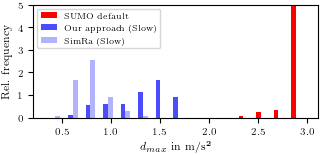

In [20]:
# d_max - slow
# plt.subplots(figsize = (10, 5))
red = matplotlib.colors.to_rgba('red', alpha=1)
blue = matplotlib.colors.to_rgba('blue', alpha=0.7)
lightblue = matplotlib.colors.to_rgba('blue', alpha=0.3)
colors = [red, blue, lightblue]
plt.hist([np.absolute(max_decs_arr[4]), np.absolute(max_decs_arr[1]), np.absolute(d_simra_slow.values.flatten())], bins = 15, label=['SUMO default', 'Our approach (Slow)', 'SimRa (Slow)'], color = colors, density=True)
plt.legend()
plt.ylim(0,5)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$d_{max}$ in m/s²')
plt.savefig('images/sim_frauentorgraben_dec_slow.pdf', bbox_inches='tight')
plt.show()

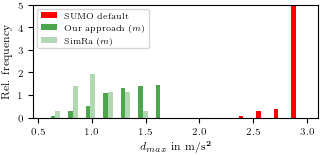

In [21]:
# d_max - medium
# plt.subplots(figsize = (10, 5))
red = matplotlib.colors.to_rgba('red', alpha=1)
green = matplotlib.colors.to_rgba('green', alpha=0.7)
lightgreen = matplotlib.colors.to_rgba('green', alpha=0.3)
colors = [red, green, lightgreen]
plt.hist([np.absolute(max_decs_arr[4]), np.absolute(max_decs_arr[2]), np.absolute(d_simra_medium.values.flatten())], bins = 15, label=['SUMO default', r'Our approach ($m$)', r'SimRa ($m$)'], color = colors, density=True)
plt.legend()
plt.ylim(0,5)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$d_{max}$ in m/s²')
plt.savefig('images/sim_frauentorgraben_dec_medium.pdf', bbox_inches='tight')
plt.show()

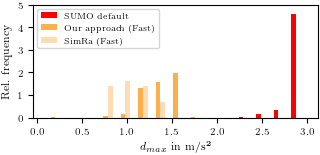

In [22]:
# d_max - fast
# plt.subplots(figsize = (10, 5))
red = matplotlib.colors.to_rgba('red', alpha=1)
orange = matplotlib.colors.to_rgba('darkorange', alpha=0.7)
lightorange = matplotlib.colors.to_rgba('darkorange', alpha=0.3)
colors = [red, orange, lightorange]
plt.hist([np.absolute(max_decs_arr[4]), np.absolute(max_decs_arr[3]), np.absolute(d_simra_medium.values.flatten())], bins = 15, label=['SUMO default', 'Our approach (Fast)', 'SimRa (Fast)'], color = colors, density=True)
plt.legend()
plt.ylim(0,5)
plt.ylabel('Rel. frequency')
plt.xlabel(r'$d_{max}$ in m/s²')
plt.savefig('images/sim_frauentorgraben_dec_fast.pdf', bbox_inches='tight')
plt.show()